# Importation

In [1]:
import pandas as pd
from matplotlib.pyplot import *
import numpy as np
import pickle
from datetime import *
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor as RFR
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Data Creation

In [2]:
x_data = pd.read_csv('data/dragon_subset.csv')
target = pd.read_csv('data/target.csv')

X_train, X_test, y_train, y_test = train_test_split(x_data, target, test_size=0.25, stratify=pd.qcut(target['density_Kg/m3'], 10).astype('str'), random_state=42)

X_train.index = range(len(X_train))
X_test.index = range(len(X_test))
y_train.index = range(len(y_train))
y_test.index = range(len(y_test))

target_mean = y_train.mean()[0]
target_std = y_train.std()[0]

y_train_scaled = (y_train - target_mean)/target_std
y_test_scaled = (y_test - target_mean)/target_std

print('target_mean : {}'.format(target_mean))
print('target_std : {}'.format(target_std))

target_mean : 1268.81408
target_std : 90.65478611528769


# L1 (LASSO) Regression

In [3]:
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train.values, y_train_scaled.values)

with open('chemml_lasso.pickle', 'wb') as handle:
    pickle.dump(lasso_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

y_train_predicted = [(_*target_std)+target_mean for _ in list(lasso_model.predict(X_train))]
y_test_predicted = [(_*target_std)+target_mean for _ in list(lasso_model.predict(X_test))]

df_train_lasso = pd.concat([y_train, pd.DataFrame({'predicted_density': y_train_predicted})], ignore_index=False, axis=1)
df_test_lasso = pd.concat([y_test, pd.DataFrame({'predicted_density': y_test_predicted})], ignore_index=False, axis=1)

df_train_lasso.to_csv('data/df_train_actual_vs_predicted_lasso.csv', index=False)
df_test_lasso.to_csv('data/df_test_actual_vs_predicted_lasso.csv', index=False)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.389e+01, tolerance: 3.740e-02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


# LASSO Coefficients

In [11]:
df_lasso_coeffs = pd.DataFrame({'feature': list(X_train.columns), 'coefficients': list(lasso_model.coef_)})
df_lasso_coeffs['abs_'] = df_lasso_coeffs.coefficients.abs()
df_lasso_coeffs.sort_values(by='abs_', ascending=False, inplace=True)
df_lasso_coeffs.index = range(len(df_lasso_coeffs))
df_lasso_coeffs.drop(columns='abs_', axis=1, inplace=True)
df_lasso_coeffs.to_csv('data/df_lasso_coefficients.csv', index=False)


# Hyper Parameter Tuning for XGBOOST & RandomForest

In [12]:
def objective_fn_rfr(params):
    global it_, scores_
    params = {
        'max_depth': int(params['max_depth']),
        'n_estimators': int(params['n_estimators']),
        'min_samples_split': params['min_samples_split'],
        'min_samples_leaf': params['min_samples_leaf'],
        'max_features': params['max_features'],
        'oob_score': params['oob_score'],
        'max_samples': params['max_samples']
    }
    
    clf = RFR(n_jobs=3,**params)

    it_ = it_ + 1
    score = cross_val_score(clf, X_train.values, y_train_scaled.values.ravel(), scoring='neg_root_mean_squared_error', cv=4).mean()
    
    with open("logs_rf.txt", "a") as myfile:
        myfile.write('------------------- On {} ------------------\n'.format(it_))
        myfile.write('Params : {}\n'.format(params))
        myfile.write('RMSE : {}\n'.format(-score))

    return {'loss': 1 - score, 'status': STATUS_OK}


def objective_fn_xgb(params):
    global it_, scores_
    params = {
        'max_depth': int(params['max_depth']),
        'n_estimators': int(params['n_estimators']),
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda']
    }
    
    clf = XGBRegressor(learning_rate=0.01,n_jobs=3,**params)

    it_ = it_ + 1
    score = cross_val_score(clf, X_train.values, y_train_scaled.values, scoring='neg_root_mean_squared_error', cv=4).mean()
    
    with open("logs_rf.txt", "a") as myfile:
        myfile.write('------------------- On {} ------------------\n'.format(it_))
        myfile.write('Params : {}\n'.format(params))
        myfile.write('RMSE : {}\n'.format(-score))

    return {'loss': 1 - score, 'status': STATUS_OK}

# XGBOOST

In [4]:
space = {
    'max_depth': hp.choice('max_depth', [5, 7, 10]),
    'n_estimators': hp.choice('n_estimators', [50, 100, 150, 200]),
    'reg_alpha': hp.choice('reg_alpha', [0.01, 0.1, 0.5, 1]),
    'reg_lambda': hp.choice('reg_lambda', [0.01, 0.1, 0.5, 1])}

it_ = 0
scores_ = list()
best_xgboost = fmin(fn=objective_fn_xgb, space=space, algo=tpe.suggest, max_evals=800)


 34%|███▍      | 275/800 [28:15<53:56,  6.16s/trial, best loss: 1.343347484427371]  


KeyboardInterrupt: 

# RandomForest

In [13]:
space = {
    'max_depth': hp.choice('max_depth', [5, 7, 10]),
    'n_estimators': hp.choice('n_estimators', [50, 125, 200]),
    'min_samples_split': hp.choice('min_samples_split', [2, 4, 6]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 3, 5]),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']),
    'oob_score': hp.choice('oob_score', [True, False]),
    'max_samples': hp.choice('max_samples', [100, 150, 200])}

it_ = 0
scores_ = list()
best_rf = fmin(fn=objective_fn_rfr, space=space, algo=tpe.suggest, max_evals=1500)


100%|██████████| 1500/1500 [1:24:52<00:00,  3.40s/trial, best loss: 1.2910824841767337]


# Dump the best XGBOOST model

In [5]:
params = {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0.01, 'reg_lambda': 0.01}
model_ = XGBRegressor(**params)
model_.fit(X_train, y_train_scaled, verbose=True)
with open('chemml_xgboost.pickle', 'wb') as handle:
    pickle.dump(model_, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Dump the best RandomForest model

In [41]:
params = {'max_depth': 10, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'oob_score': True, 'max_samples': 200}
model_ = RFR(**params)
model_.fit(X_train.values, y_train_scaled.values.ravel())
with open('chemml_rfr.pickle', 'wb') as handle:
    pickle.dump(model_, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the saved models

In [16]:
with open('chemml_xgboost.pickle', 'rb') as input_file:
    model_xgb = pickle.load(input_file)

with open('chemml_rfr.pickle', 'rb') as input_file:
    model_rfr = pickle.load(input_file)

# Density Prediction for Training & Testing

# XGBOOST

In [20]:
y_train_predicted = [(_*target_std)+target_mean for _ in list(model_xgb.predict(X_train))]
y_test_predicted = [(_*target_std)+target_mean for _ in list(model_xgb.predict(X_test))]

df_train_xgb = pd.concat([y_train, pd.DataFrame({'predicted_density': y_train_predicted})], ignore_index=False, axis=1)
df_test_xgb = pd.concat([y_test, pd.DataFrame({'predicted_density': y_test_predicted})], ignore_index=False, axis=1)

df_train_xgb.to_csv('data/df_train_actual_vs_predicted_xgb.csv', index=False)
df_test_xgb.to_csv('data/df_test_actual_vs_predicted_xgb.csv', index=False)

rms_xgb = sqrt(mean_squared_error(y_test['density_Kg/m3'].values, y_test_predicted))

# RandomForest

In [21]:
y_train_predicted = [(_*target_std)+target_mean for _ in list(model_rfr.predict(X_train))]
y_test_predicted = [(_*target_std)+target_mean for _ in list(model_rfr.predict(X_test))]

df_train_rfr = pd.concat([y_train, pd.DataFrame({'predicted_density': y_train_predicted})], ignore_index=False, axis=1)
df_test_rfr = pd.concat([y_test, pd.DataFrame({'predicted_density': y_test_predicted})], ignore_index=False, axis=1)

df_train_rfr.to_csv('data/df_train_actual_vs_predicted_rfr.csv', index=False)
df_test_rfr.to_csv('data/df_test_actual_vs_predicted_rfr.csv', index=False)

rms_rfr = sqrt(mean_squared_error(y_test['density_Kg/m3'].values, y_test_predicted))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


# Feature Importances

# XGBOOST

In [24]:
df_features = pd.DataFrame({'feature': list(X_train.columns), 'importance': list(model_xgb.feature_importances_)})
df_features.sort_values(by='importance', ascending=False, inplace=True)
df_features.index = range(len(df_features))
df_features.importance = round((df_features.importance/df_features.importance.sum())*100, 2)
df_features.to_csv('data/df_feature_importance_xgb.csv', index=False)

# RandomForest

In [26]:
df_features = pd.DataFrame({'feature': list(X_train.columns), 'importance': list(model_rfr.feature_importances_)})
df_features.sort_values(by='importance', ascending=False, inplace=True)
df_features.index = range(len(df_features))
df_features.importance = round((df_features.importance/df_features.importance.sum())*100, 2)
df_features.to_csv('data/df_feature_importance_rfr.csv', index=False)

# Principal Component Analysis

In [28]:
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=200))])

X_PC = pipeline.fit_transform(x_data)
df_pc = pd.DataFrame(X_PC, columns=['PC_{}'.format(_) for _ in range(1, 201)])[['PC_1', 'PC_2']]
#df_pc.to_csv('df_principal_components.csv', index=False)
df_variance = pd.DataFrame({'principal_component': ['PC_{}'.format(_) for _ in range(1, 201)], 'variance_captured': [round(_*100, 3) for _ in pipeline['pca'].explained_variance_ratio_]})
df_variance.to_csv('data/df_percent_variance_captured_in_PCA.csv', index=False)


[60.294,
 11.009,
 7.86,
 5.636,
 3.71,
 2.876,
 1.71,
 1.462,
 1.204,
 0.779,
 0.532,
 0.49,
 0.433,
 0.313,
 0.241,
 0.199,
 0.178,
 0.141,
 0.112,
 0.098,
 0.087,
 0.077,
 0.071,
 0.065,
 0.049,
 0.046,
 0.038,
 0.027,
 0.026,
 0.025,
 0.02,
 0.018,
 0.017,
 0.016,
 0.013,
 0.012,
 0.011,
 0.009,
 0.008,
 0.008,
 0.007,
 0.007,
 0.006,
 0.006,
 0.005,
 0.004,
 0.004,
 0.004,
 0.003,
 0.003,
 0.002,
 0.002,
 0.002,
 0.002,
 0.002,
 0.002,
 0.002,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.

# K-Means Clustering

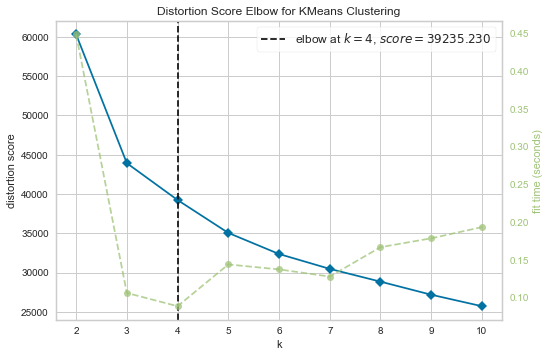

(array([1., 0., 2., 1., 1., 2., 1., 3., 6., 2.]),
 array([1049.98 , 1090.274, 1130.568, 1170.862, 1211.156, 1251.45 ,
        1291.744, 1332.038, 1372.332, 1412.626, 1452.92 ]),
 <BarContainer object of 10 artists>)

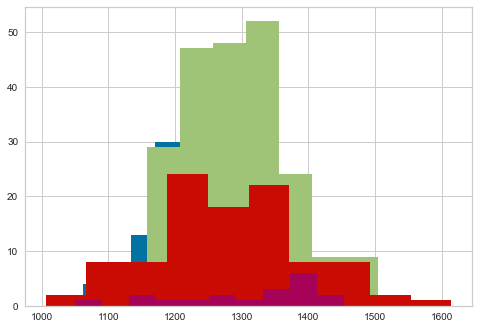

In [35]:
scaler_ = StandardScaler()
scaler_.fit(x_data)
x_scaled = scaler_.transform(x_data)

k_means = KMeans()
visualizer = KElbowVisualizer(k_means, k=(2, 11))

visualizer.fit(x_scaled)
visualizer.show()

kmeans_ = KMeans(n_clusters=4, random_state=42).fit(x_scaled)
df_cluster = pd.concat([target, pd.DataFrame({'label': kmeans_.labels_})], ignore_index=False, axis=1)

m = pd.read_csv('molecules.csv').rename(columns={'smiles': 'molecule'})
df_cluster = pd.concat([df_cluster, m], ignore_index=False, axis=1)
df_cluster.to_csv('data/df_cluster_allocation.csv', index=False)

with open('chemml_kmeans.pickle', 'wb') as handle:
    pickle.dump(kmeans_, handle, protocol=pickle.HIGHEST_PROTOCOL)
